In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
import tensorflow as tf

C:\Users\Acer\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Acer\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Acer\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Acer\Anaconda3\envs\tf_gpu\lib\site-packages\tensorflow\python\f

In [3]:
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True)) #To check if its using GPU

In [4]:
df = pd.read_csv('IndiaBulls.csv')
df.shape

(754, 13)

In [5]:
df.isnull().sum()

Date                         0
Open Price                   0
High Price                   0
Low Price                    0
Close Price                  0
WAP                          0
No.of Shares                 0
No. of Trades                0
Total Turnover (Rs.)         0
Deliverable Quantity         1
% Deli. Qty to Traded Qty    1
Spread High-Low              0
Spread Close-Open            0
dtype: int64

In [6]:
df.dropna(inplace = True)
df.reset_index(drop = True, inplace = True)
df.isnull().sum()

Date                         0
Open Price                   0
High Price                   0
Low Price                    0
Close Price                  0
WAP                          0
No.of Shares                 0
No. of Trades                0
Total Turnover (Rs.)         0
Deliverable Quantity         0
% Deli. Qty to Traded Qty    0
Spread High-Low              0
Spread Close-Open            0
dtype: int64

In [7]:
len(df['Low Price'])
Train = df.iloc[:501,:]
Test = df.iloc[501:,:]
print(Train.shape)
print(Test.shape)
Test.head()

(501, 13)
(252, 13)


,Date,Open Price,High Price,Low Price,Close Price,WAP,No.of Shares,No. of Trades,Total Turnover (Rs.),Deliverable Quantity,% Deli. Qty to Traded Qty,Spread High-Low,Spread Close-Open
501,11-Oct-18,925.00,936.00,862.00,893.35,901.180631,843912,19767,760517149,156660.0,18.56,74.00,-31.65
502,12-Oct-18,904.00,941.05,904.00,931.10,930.524633,373143,9086,347218753,43503.0,11.66,37.05,27.10
503,15-Oct-18,947.70,960.20,929.30,948.70,948.143195,343916,11006,326081615,56176.0,16.33,30.90,1.00
504,16-Oct-18,964.80,976.85,896.75,908.45,930.284965,874484,18243,813519317,119299.0,13.64,80.10,-56.35
505,17-Oct-18,918.75,919.90,780.00,788.85,825.817126,2085605,44999,1722328327,281556.0,13.50,139.90,-129.90


In [13]:
class Agent:

    LEARNING_RATE = 1e-3
    LAYER_SIZE = 256
    GAMMA = 0.9
    OUTPUT_SIZE = 3

    def __init__(self, state_size, window_size, trend,trend_test, skip):
        self.state_size = state_size
        self.window_size = window_size
        self.half_window = window_size // 2
        self.trend = trend
        self.skip = skip
        self.trend_test = trend_test
        tf.reset_default_graph()
        self.X = tf.placeholder(tf.float32, (None, self.state_size))
        self.REWARDS = tf.placeholder(tf.float32, (None))
        self.ACTIONS = tf.placeholder(tf.int32, (None))
        feed_forward = tf.layers.dense(self.X, self.LAYER_SIZE, activation = tf.nn.relu)
        self.logits = tf.layers.dense(feed_forward, self.OUTPUT_SIZE, activation = tf.nn.softmax)
        
        input_y = tf.one_hot(self.ACTIONS, self.OUTPUT_SIZE)
        loglike = tf.log((input_y * (input_y - self.logits) + (1 - input_y) * (input_y + self.logits)) + 1)
        rewards = tf.tile(tf.reshape(self.REWARDS, (-1,1)), [1, self.OUTPUT_SIZE])
        self.cost = -tf.reduce_mean(loglike * (rewards + 1)) 
        self.optimizer = tf.train.AdamOptimizer(learning_rate = self.LEARNING_RATE).minimize(self.cost)
        self.sess = tf.InteractiveSession()
        self.sess.run(tf.global_variables_initializer())
    
    def predict(self, inputs):
        return self.sess.run(self.logits, feed_dict={self.X:inputs})
    
    def get_state_train(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend[d : t + 1] if d >= 0 else -d * [self.trend[0]] + self.trend[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def get_state_test(self, t):
        window_size = self.window_size + 1
        d = t - window_size + 1
        block = self.trend_test[d : t + 1] if d >= 0 else -d * [self.trend_test[0]] + self.trend_test[0 : t + 1]
        res = []
        for i in range(window_size - 1):
            res.append(block[i + 1] - block[i])
        return np.array([res])
    
    def discount_rewards(self, r):
        discounted_r = np.zeros_like(r)
        running_add = 0
        for t in reversed(range(0, r.size)):
            running_add = running_add * self.GAMMA + r[t]
            discounted_r[t] = running_add
        return discounted_r
    
    def get_predicted_action(self, sequence):
        prediction = self.predict(np.array(sequence))[0]
        return np.argmax(prediction)
    
    def buy(self, initial_money,Validate_profit):
        Date = Test.Date
        starting_money = initial_money
        states_sell = []
        states_buy = []
        inventory = []
        trade_act = []
        trade_act = []  
        Dates = []      
        Profit = []     
        Money  = []
        state = self.get_state_test(0)
        for t in range(0,len(self.trend_test)-1, self.skip):
            action = self.get_predicted_action(state)
            next_state = self.get_state_test(t + 1)
            
            
            if action == 1 and initial_money >= self.trend_test[t] and t < (len(self.trend_test) - self.half_window):
                inventory.append(self.trend_test[t])
                initial_money -= self.trend_test[t]
                states_buy.append(t)
                trade_act.append('buy')   
                Dates.append(Date[501+t])  
                Profit.append(initial_money - starting_money)  
                Money.append(initial_money) 
#                 print('day %d: buy 1 unit at price %f, total balance %f'%
#                       (t, self.trend_test[t], initial_money))
                
                
            elif action == 2 and len(inventory):
                bought_price = inventory.pop(0)
                initial_money += self.trend_test[t]
                states_sell.append(t)
                trade_act.append('sell')   
                Dates.append(Date[501+t]) 
                Profit.append(initial_money - starting_money)  
                Money.append(initial_money)
                try:
                    invest = ((close[t] - bought_price) / bought_price) * 100
                except:
                    invest = 0
#                 print('day %d, sell 1 unit at price %f, investment %f %%, total balance %f,'% 
#                      (t, close[t], invest, initial_money))
            elif action == 0:
                trade_act.append('hold')   
                Dates.append(Date[501+t])  
                Profit.append(0) 
                Money.append(initial_money)
            
            state = next_state
        invest = ((initial_money - starting_money) / starting_money) * 100
        total_gains = initial_money - starting_money
        Validate_profit.append(total_gains)
        return states_buy, states_sell, total_gains, invest,Validate_profit,trade_act,Dates,Profit,Money
        
    
    def train(self, iterations, checkpoint, initial_money):
        iters = []
        Train_profit = []
        Validate_profit = []
        for i in range(iterations):
            close = trend
            Date = Train.Date
            ep_history = []
            total_profit = 0
            step_profit = []
            inventory = []
            iters.append(i+1)
            state = self.get_state_train(0)
            starting_money = initial_money
            for t in range(0, len(self.trend) - 1, self.skip):
                action = self.get_predicted_action(state)
                next_state = self.get_state_train(t + 1)
                if action == 1 and starting_money >= self.trend[t] and t < (len(self.trend) - self.half_window):
                    inventory.append(self.trend[t])
                    starting_money -= close[t]
                
                elif action == 2 and len(inventory):
                    bought_price = inventory.pop(0)
                    total_profit += self.trend[t] - bought_price
                    starting_money += self.trend[t]
                                
                ep_history.append([state,action,starting_money,next_state])
                state = next_state
            ep_history = np.array(ep_history)
            ep_history[:,2] = self.discount_rewards(ep_history[:,2])
            cost, _ = self.sess.run([self.cost, self.optimizer], feed_dict={self.X:np.vstack(ep_history[:,0]),
                                                    self.REWARDS:ep_history[:,2],
                                                    self.ACTIONS:ep_history[:,1]})
            gains = starting_money - initial_money 
            Train_profit.append(gains)
            states_buy, states_sell, total_gains, invest,Validate_profit,trade_act,Dates,Profit,Money = agent.buy(initial_money,Validate_profit)            
            if (i+1) % checkpoint == 0:
                print('epoch: %d, total rewards: %f.3,total money: %f,Train_profit: %f,Validate_profit:%f'% #removed cost
                      (i + 1, total_profit,starting_money,gains,total_gains))
            if total_gains >= 150 :
                break
                print("Breaking the loop validate profit:",total_gains)
        
        return Train_profit,Validate_profit,iters

In [14]:
trend = Train['Close Price'].values.tolist()
trend_test = Test['Close Price'].values.tolist()
initial_money = 10000
window_size = 30
skip = 1
agent = Agent(state_size = window_size,
             window_size = window_size,
             trend = trend,
            trend_test = trend_test,
             skip = skip)


Train_profit,Validate_profit,iters = agent.train(iterations = 50, checkpoint = 1, initial_money = initial_money)

epoch: 1, total rewards: 58.750000.3,total money: 10058.750000,Train_profit: 58.750000,Validate_profit:82.900000
epoch: 2, total rewards: 748.900000.3,total money: 8321.900000,Train_profit: -1678.100000,Validate_profit:243.150000


# Testing

In [15]:
states_buy, states_sell, total_gains, invest,Validate_profit,trade_act,Dates,Profit,Money = agent.buy(initial_money,Validate_profit) #change

In [17]:
iters.append(3)

In [18]:
IndiaBulls_Model_3 = pd.DataFrame({'Epochs':iters,'IndiaBulls Profit': Validate_profit})#'Train Profit':Train_profit
IndiaBulls_Model_3.to_csv('Models/IndiaBulls/IndiaBulls_Model_3.csv')
IndiaBulls_Prediction_1 = pd.DataFrame({"Date":Dates,"Actions":trade_act,"Profit":Profit,"Current Money":Money})
IndiaBulls_Prediction_1.to_csv("Models/IndiaBulls/IndiaBulls_Prediction_1.csv")

In [26]:
df1 = pd.read_csv('Models/IndiaBulls/IndiaBulls_Model_1.csv')
df1.head(2)

,Epochs,IndiaBulls Profit
0,1,12.15
1,2,12.15


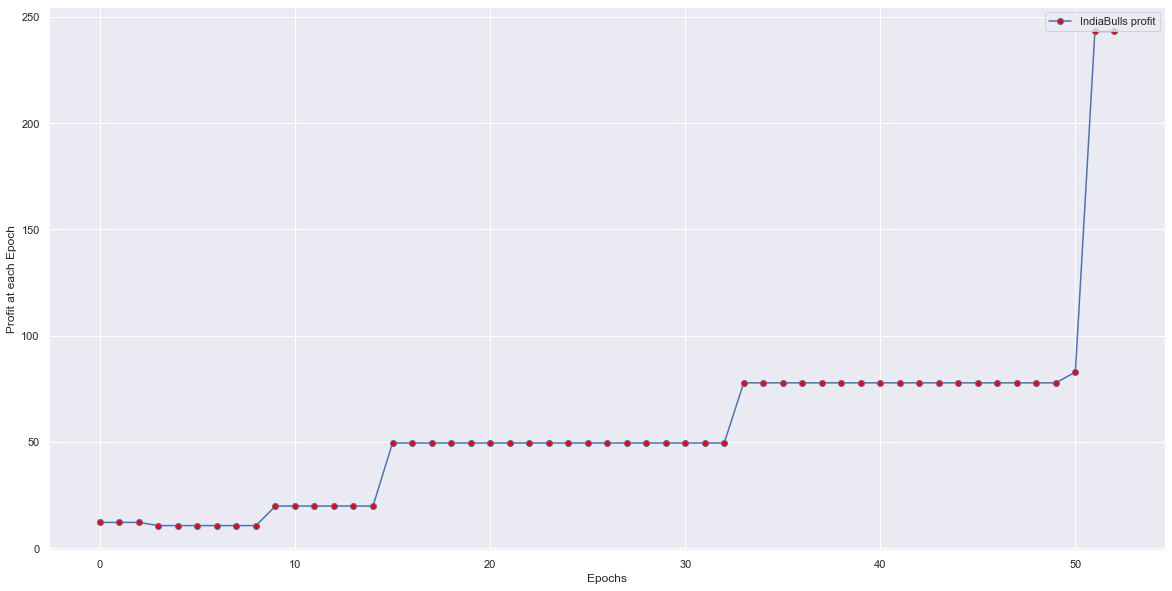

In [29]:
fig = plt.figure(figsize = (20,10))
#plt.plot(Train_profit,marker='o', markerfacecolor='blue',label = 'Train profit')
plt.plot(df1['IndiaBulls Profit'],marker='o', markerfacecolor='red',label = 'IndiaBulls profit')
plt.xlabel('Epochs')
plt.ylabel('Profit at each Epoch')
plt.legend()
plt.savefig('Models/IndiaBulls/IndiaBulls_Model_3')
plt.show()

In [19]:
len(trend_test)

252

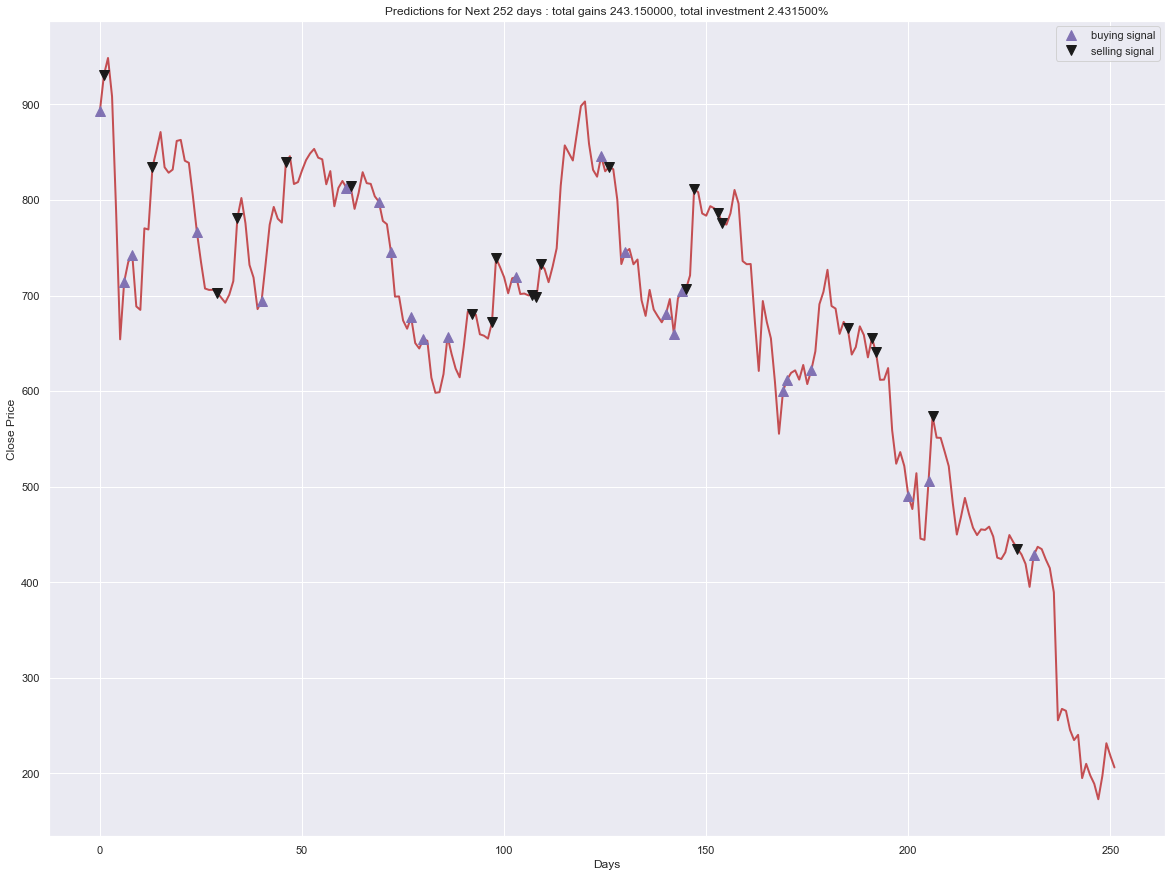

In [21]:
fig = plt.figure(figsize = (20,15))
plt.plot(trend_test, color='r', lw=2.)
plt.plot(trend_test, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(trend_test, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('Predictions for Next 252 days : total gains %f, total investment %f%%'%(total_gains, invest))
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.savefig('Models/IndiaBulls/IndiaBulls Chart')
plt.show()

In [ ]:
Performance = pd.read_csv('Models/Best/Performance.csv')

In [ ]:
fig = plt.figure(figsize = (20,10))
plt.plot(Performance.Close,marker='o', markerfacecolor='blue',label = 'Close')
plt.plot(Performance.High,marker='o', markerfacecolor='red',label = 'High')
plt.plot(Performance.Low,marker='o', markerfacecolor='Green',label = 'Low')
plt.plot(Performance.Open,marker='o', markerfacecolor='Yellow',label = 'Open')
plt.xlabel('Days')
plt.ylabel('Total Profit')
plt.legend()
plt.savefig('Models/SBI/Performance')
plt.show()


In [ ]:
Year_Performance = pd.read_csv('Models/Best/Year_performance.csv')
Year_Performance.head()

In [ ]:
Year_Performance['1 year']

In [ ]:
fig = plt.figure(figsize = (20,10))
plt.plot(Year_Performance['1 year'],marker='o', markerfacecolor='blue',label = '1 year')
plt.plot(Year_Performance['2 years'],marker='o', markerfacecolor='red',label = '2 years')
plt.plot(Year_Performance['3 years'],marker='o', markerfacecolor='Green',label = '3 years')
plt.plot(Year_Performance['4 years'],marker='o', markerfacecolor='Yellow',label = '4 years')
plt.xlabel('Days')
plt.ylabel('Total Profit')
plt.legend()
plt.savefig('Models/Best/Year_Performance')
plt.show()


# Testing

In [ ]:
fig = plt.figure(figsize = (15,5))
plt.plot(trend_test, color='r', lw=2.)
plt.plot(trend_test, '^', markersize=10, color='m', label = 'buying signal', markevery = states_buy)
plt.plot(trend_test, 'v', markersize=10, color='k', label = 'selling signal', markevery = states_sell)
plt.title('Predictions for Next 251 days : total gains %f, total investment %f%%'%(total_gains, invest))
plt.xlabel('Days')
plt.ylabel('Close Price')
plt.legend()
plt.show()